## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, joule, meter, pascals, kilojoule
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_601565/2833670413.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.



****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



## Loading data and creating atom group of ions

In [2]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname SOD CLA')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

box_size = u.dimensions[:3] * angstrom
print(box_size)
half_box=box_size[2]/2
print(half_box)


[ 48.  48. 144.] A
72.0 A


In [3]:
k= 1.0457*(kilojoule_per_mole/nanometer**2)
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant
vanthoff_nu=2
temp=300*kelvin

In [4]:
# def osmotic_ideal(molarity, vant_hoff:int=2, T=300*kelvin):
#     osm_press_ideal=vant_hoff*molarity*R*T
#     osm_press_ideal=osm_press_ideal.in_units_of(bar)
#     print(f"Osmotic Pressure Ideal:", osm_press_ideal)
#     return osm_press_ideal

# oi1=osmotic_ideal(0.976*(mole/litre),2,300*kelvin)
# oi2=osmotic_ideal(1.923*(mole/litre),2,300*kelvin)
# oi3=osmotic_ideal(2.823*(mole/litre),2,300*kelvin)

def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff=vanthoff_nu, T=temp):
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentraion {molarity}')
    print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar


In [5]:
# xz,yz = np.loadtxt("density_hwr1.xvg",comments=["@", "#"],unpack=True)
# ## Assign units to number density values and convert them to concentration units mol/L 
# yz=(yz/nanometer**3)/(AVOGADRO_CONSTANT_NA)
# yz=yz.in_units_of(mole/litre)/2

# halfz=int((len(yz)/2)-1)
# print(yz[halfz])
# ## Average concentration from both sides of the middle of the box (7.2 nm) 
# yz1=yz[:halfz+1]
# print(yz1)
# yz2=yz[halfz:-1]
# yz2=yz2[::-1]
# yz1 = np.array(yz1)
# yz2 = np.array(yz2)
# av_y=[(a+b)/2 for a,b in zip(yz1,yz2)]
# av_C=av_y[::-1]
# av_C=np.array(av_C)*(mole/litre)
# xz2=np.array(xz[:halfz+1])*nanometer
# print(av_C,len(av_C))

In [6]:
##Function to symmetrize to the median of the density plot
def conc_prof_hw(filename):
    xz,yz = np.loadtxt(filename,comments=["@", "#"],unpack=True)
    ## Assign units to number density values and convert them to concentration units mol/L 
    yz=(yz/nanometer**3)/(AVOGADRO_CONSTANT_NA)
    yz=yz.in_units_of(mole/litre)/2
    halfz=int((len(yz)/2)-1)
    ## Average concentration from both sides of the middle of the box (7.2 nm) 
    yz1=yz[:halfz+1]
    yz2=yz[halfz:-1]
    yz2=yz2[::-1]
    yz1 = np.array(yz1)
    yz2 = np.array(yz2)
    av_y=[(a+b)/2 for a,b in zip(yz1,yz2)]
    av_C=av_y[::-1]
    av_C=np.array(av_C)*(mole/litre)
    xz2=np.array(xz[:halfz+1])*nanometer
    return xz2, av_C

## Function to calculate Osmotic Pressure
def calculate_pi(z_coordinates,z_concentrations,pi_1:Quantity,springk,vanthoff=vanthoff_nu):
    
    z_coordinates=z_coordinates[::-1]
    z_concentrations=z_concentrations[::-1]
    delta_z=z_coordinates[0]-z_coordinates[1]
    pi_results = []

    ## Calculate Pi_2 stepwise
    for i in range(len(z_concentrations)-1):
        #print(pi_1)
        
        ## Calculate the average of concentration
        phi_avg = (z_concentrations[i+1] + z_concentrations[i]) / 2
        #print(phi_avg)
        
        ## Calculate the average of z coordinates
        z_avg = (z_coordinates[i+1] + z_coordinates[i]) / 2
        #print(z_avg)
        
        ## Calculate Pi_2
        fact1=vanthoff*phi_avg*z_avg*springk*delta_z
        fact2=(fact1.in_units_of(joule/meter**3)).in_units_of(pascals)
        mult_fact=fact2.in_units_of(bar)
        pi_2 = pi_1 + mult_fact
        pi_results.append(pi_2._value)

        ## Set pi_2 as the new pi_1 for next iteration
        pi_1=pi_2


    # #print(f'phi_avg final = {phi_avg}, z_avg final = {z_avg}, fact1 = {fact1}, pi_2 = {pi_2}')
    return z_concentrations, pi_results

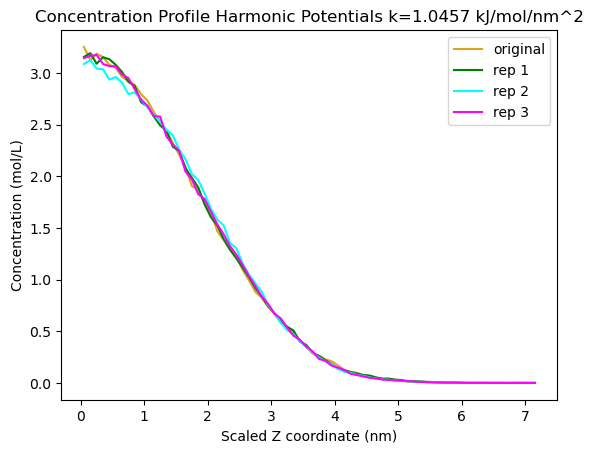

In [7]:
original_x, original_y = conc_prof_hw("density_hwl.xvg")
r1_x, r1_y = conc_prof_hw("density_hwr1.xvg")
r2_x, r2_y = conc_prof_hw("density_hwr2.xvg")
r3_x, r3_y = conc_prof_hw("density_hwr3.xvg")

##Plot concentration gradient
plt.plot(original_x, original_y, c='goldenrod', label='original')
plt.plot(r1_x, r1_y, c='green', label='rep 1')
plt.plot(r2_x, r2_y, c='cyan', label='rep 2')
plt.plot(r3_x, r3_y, c='magenta', label='rep 3')
plt.xlabel("Scaled Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 7.2, 1.0))
plt.yticks(np.arange(0, 3.5, 0.5))
plt.title('Concentration Profile Harmonic Potentials k=1.0457 kJ/mol/nm^2')
plt.legend()
plt.show()

## Fittings

In [8]:
# import scipy as sp
# from scipy.interpolate import interp1d

# x = original_x
# y = original_y

# coeffs = np.polyfit(x, y, deg=6)#you can change degree as you see fit
# poly = np.poly1d(coeffs)
# yp = np.polyval(poly, x)

# interpLength = 72
# new_x = np.linspace(x.min(), x.max(), interpLength)
# new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)


# plt.plot(x, y, '.', x, yp, '-', new_x,new_y, '--')
# plt.show()

In [9]:
import scipy.optimize as optimization

In [10]:
print(original_y)

[3.25403387e+00 3.12707736e+00 3.18929360e+00 3.15584619e+00
 3.08104306e+00 3.05155189e+00 2.96343953e+00 2.92423836e+00
 2.88683887e+00 2.79620664e+00 2.73578793e+00 2.62393817e+00
 2.53115140e+00 2.44159853e+00 2.32435616e+00 2.20747497e+00
 2.09238716e+00 1.90429790e+00 1.87804478e+00 1.73706501e+00
 1.65218656e+00 1.46877171e+00 1.38389741e+00 1.29506687e+00
 1.22241829e+00 1.09294606e+00 9.91889801e-01 8.81839650e-01
 8.23935407e-01 7.35466037e-01 6.66414596e-01 5.83696918e-01
 5.40540338e-01 4.88751445e-01 4.15744600e-01 3.54246120e-01
 2.84835587e-01 2.64335817e-01 2.28731369e-01 2.09670456e-01
 1.69031253e-01 1.28032129e-01 1.07532442e-01 9.78223564e-02
 7.69632044e-02 6.76124598e-02 5.50250340e-02 3.59640381e-02
 3.63237109e-02 2.12187833e-02 1.94206271e-02 1.36663611e-02
 1.51049276e-02 1.33067298e-02 4.67533077e-03 6.11390143e-03
 3.23676426e-03 2.15784270e-03 1.43856651e-03 1.43856360e-03
 7.19283254e-04 3.59640797e-04 1.07892280e-03 7.19281593e-04
 7.19281593e-04 7.192832

In [11]:
oriy=original_y
oriy=oriy.value_in_unit(oriy.unit)
print(oriy)

[3.25403387e+00 3.12707736e+00 3.18929360e+00 3.15584619e+00
 3.08104306e+00 3.05155189e+00 2.96343953e+00 2.92423836e+00
 2.88683887e+00 2.79620664e+00 2.73578793e+00 2.62393817e+00
 2.53115140e+00 2.44159853e+00 2.32435616e+00 2.20747497e+00
 2.09238716e+00 1.90429790e+00 1.87804478e+00 1.73706501e+00
 1.65218656e+00 1.46877171e+00 1.38389741e+00 1.29506687e+00
 1.22241829e+00 1.09294606e+00 9.91889801e-01 8.81839650e-01
 8.23935407e-01 7.35466037e-01 6.66414596e-01 5.83696918e-01
 5.40540338e-01 4.88751445e-01 4.15744600e-01 3.54246120e-01
 2.84835587e-01 2.64335817e-01 2.28731369e-01 2.09670456e-01
 1.69031253e-01 1.28032129e-01 1.07532442e-01 9.78223564e-02
 7.69632044e-02 6.76124598e-02 5.50250340e-02 3.59640381e-02
 3.63237109e-02 2.12187833e-02 1.94206271e-02 1.36663611e-02
 1.51049276e-02 1.33067298e-02 4.67533077e-03 6.11390143e-03
 3.23676426e-03 2.15784270e-03 1.43856651e-03 1.43856360e-03
 7.19283254e-04 3.59640797e-04 1.07892280e-03 7.19281593e-04
 7.19281593e-04 7.192832

In [12]:
#coefficients along a line of constant chemical potential of the water
A_M=1.7964*(mole/litre)**(-1/2)
B_M=1.9247*(mole/litre)**(-1/2)
a1_M=9.3393E-2*(mole/litre)**(-1)
a2_M=3.4572E-2*(mole/litre)**(-2)

In [13]:
#coefficients along a line of constant pressure
# A_m=1.7937*(mole/litre)**(-1/2)
# B_m=1.9247*(mole/litre)**(-1/2)
# a1_m=9.3393E-2*(mole/litre)**(-1)
# a2_m=3.4572E-2*(mole/litre)**(-2)

In [66]:
def fitting_lstsq(variables,y_data):
    A_M=1.7964*(mole/litre)**(-1/2)
    B_M=1.9247*(mole/litre)**(-1/2)
    c_s=y_data.value_in_unit(y_data.unit)
    sqrt_cs=np.sqrt(c_s)
    c_max=c_s[0]
    sqrt_cmax=np.sqrt(c_max)
    A_fit=A_M.value_in_unit(A_M.unit)
    B_fit=B_M.value_in_unit(B_M.unit)
    # alphai=alphai.value_in_unit(alphai.unit)
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = np.true_divide(c_s,c_max)
        term1[term1 == np.inf] = 0
        term1 = np.nan_to_num(term1)

    t2_denom1=np.add(1,(np.multiply(B_fit,sqrt_cmax)))
    t2_frac1=np.divide(sqrt_cmax,t2_denom1)
    t2_denom2=np.add(1,(np.multiply(B_fit,sqrt_cs)))
    t2_frac2=np.divide(sqrt_cs,t2_denom2)
    t2_inside=t2_frac1-t2_frac2
    term2=A_fit*t2_inside

    left_terms=np.add(term1,term2)
    
    i_max=[1,2]
    alphas=[variables[0],variables[1]]
    t3=sum(ai*((c_s**i)-(c_max**i)) for ai,i in zip(alphas,i_max))
    # t3=sum(alphai*((c_s**i)-(c_max**i)) for i in i_max)

    objective=np.add(left_terms, t3)
 
    return -objective+c_s

In [69]:
from scipy.optimize import leastsq
variables=[9.3393E-2,3.4572E-2]
out=optimization.leastsq(fitting_lstsq,variables,args=(original_y))
print(out[0])
newy=fitting_lstsq(out[0],original_y)
print(newy)

[ 2.48988665 -0.69842337]
[ 2.25403387e+00  1.91314850e+00  2.07740999e+00  1.98843611e+00
  1.79506406e+00  1.72095845e+00  1.50672731e+00  1.41487202e+00
  1.32922156e+00  1.12968974e+00  1.00298689e+00  7.81746627e-01
  6.11326467e-01  4.58112199e-01  2.74233616e-01  1.09754094e-01
 -3.38608482e-02 -2.29496335e-01 -2.52955873e-01 -3.62866269e-01
 -4.16008449e-01 -4.97570442e-01 -5.20004129e-01 -5.33185456e-01
 -5.36186191e-01 -5.24344858e-01 -4.99996165e-01 -4.58708499e-01
 -4.30930926e-01 -3.80652049e-01 -3.35034758e-01 -2.73398537e-01
 -2.38391070e-01 -1.93996523e-01 -1.27474397e-01 -6.85519993e-02
 -1.83431324e-04  2.00822239e-02  5.49418463e-02  7.32385309e-02
  1.10598801e-01  1.44112452e-01  1.58085588e-01  1.63724792e-01
  1.72829593e-01  1.75111319e-01  1.75663531e-01  1.67969144e-01
  1.68251690e-01  1.48679892e-01  1.44881080e-01  1.29125303e-01
  1.33683009e-01  1.27906740e-01  8.22829183e-02  9.32514083e-02
  6.84292323e-02  5.48480235e-02  4.30391307e-02  4.30390761e-02

In [40]:
# popt, pcov=optimization.curve_fit(fitting_lstsq, xdata=original_x, ydata=original_y,p0=(9.3393E-2,2),bounds=(0,3.5))
# print("Parameter estimation results:")
# print("p1 = ",popt[0]," | p2 = ",popt[1])
# print("--------------------------")
# print("Covariance matrix of the estimate:")
# print(pcov)
# print("--------------------------")
# p1 = popt[0]
# p2 = popt[1]
# residuals = oriy - fitting_lstsq(original_y,p1,p2)
# fres = sum(residuals**2)

# print("Residuals sum of squares:")
# print(fres)
# print("--------------------------")
# newy=fitting_lstsq(original_y,p1,p2)
# print(newy)

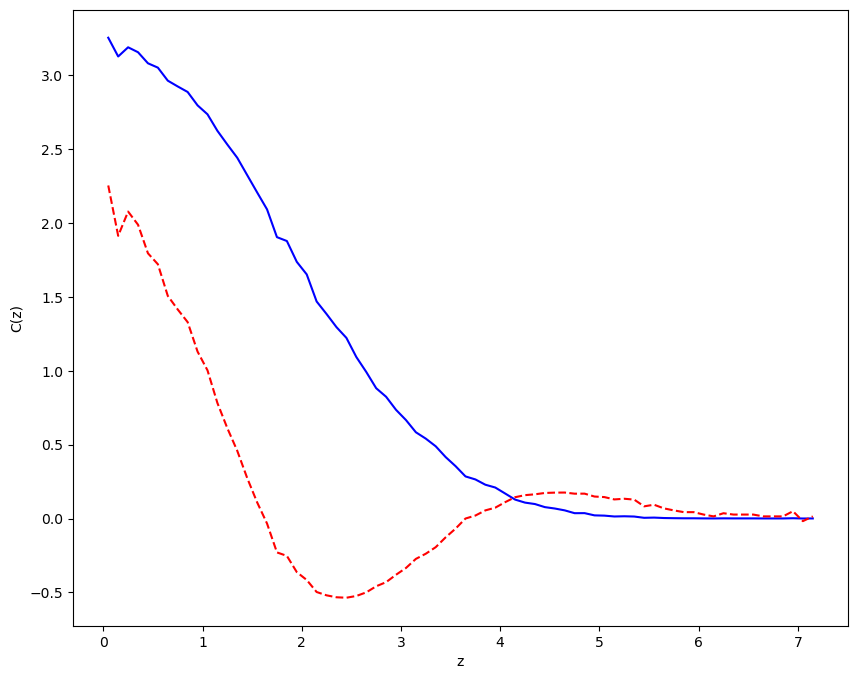

In [68]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(original_x, original_y, 'b')
plt.plot(original_x, newy, 'r--')
plt.xlabel('z')
plt.ylabel('C(z)')
plt.show()

## Calculating osmotic values

In [ ]:
## Calculate ideal osmotic pressure at max concentration to have an idea of what the value should be close to  
def osmotic_values(molality, conc_vals, osmpress_vals,repnum):
    vant_hoff=2
    T=300*kelvin

    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    if molality == 1:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-0.976*(mole/litre)))
        print(f'Osmotic values for ~1m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 2:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-1.923*(mole/litre)))
        print(f'Osmotic values for ~2m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 3:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-2.823*(mole/litre)))
        print(f'Osmotic values for ~3m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar

    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal: {osm_press_ideal}")

    osm_coeff=osm_press_obs/osm_press_ideal

    print(f"Osmotic Pressure Observed: {osm_press_obs}, Osmotic Coefficient: {osm_coeff} \n")

    tresults = dict()

    tresults['os_pres_val'] = osm_press_obs
    tresults['os_coef_val'] = osm_coeff
    tresults['m'] = molality
    tresults['repnum'] = repnum
    
    return tresults



#### (exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
#### (exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
#### (exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

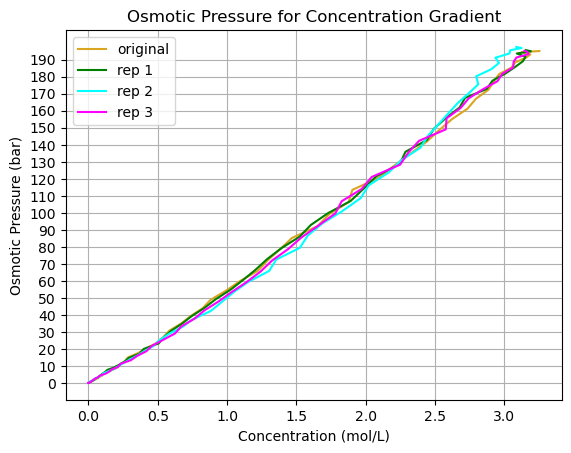

In [ ]:
z_concs_o, pi_val_o = calculate_pi(original_x, original_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r1, pi_val_r1 = calculate_pi(r1_x, r1_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r2, pi_val_r2 = calculate_pi(r2_x, r2_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r3, pi_val_r3 = calculate_pi(r3_x, r3_y, pi_1=0*bar, springk=k,vanthoff=2)


plt.plot(z_concs_o[1:], pi_val_o, c='goldenrod', label='original')
plt.plot(z_concs_r1[1:], pi_val_r1, c='green', label='rep 1')
plt.plot(z_concs_r2[1:], pi_val_r2, c='cyan', label='rep 2')
plt.plot(z_concs_r3[1:], pi_val_r3, c='magenta', label='rep 3')
plt.xlabel("Concentration (mol/L)")
plt.ylabel("Osmotic Pressure (bar)")
plt.xticks(np.arange(0, 3.5, 0.5))
plt.yticks(np.arange(0, 200, 10))
plt.title('Osmotic Pressure for Concentration Gradient')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from scipy.optimize import curve_fit
##linear function to fit
def linearFunc(x,intercept,slope):
    y = intercept + slope * x
    return y


In [ ]:
molal_conc=[1,2,3]
z_conc_vals=[z_concs_o,z_concs_r1,z_concs_r2,z_concs_r3]
pi_vals=[pi_val_o,pi_val_r1,pi_val_r2,pi_val_r3]
repnum=[0,1,2,3]

presults1m=list()
presults2m=list()
presults3m=list()


# for m in molal_conc:
for (czi,opi,rn) in zip(z_conc_vals,pi_vals,repnum):
    print(rn)
    presults1m.append(osmotic_values(1,czi,opi,rn))
    presults2m.append(osmotic_values(2,czi,opi,rn))
    presults3m.append(osmotic_values(3,czi,opi,rn))



0
Data for original run
Osmotic values for ~1m, molar concentration = 0.9918898009949537 mol/L
Osmotic Pressure Ideal: 49.482184030199996 bar
Osmotic Pressure Observed: 54.1874092578134 bar, Osmotic Coefficient: 1.0950892795019256 

Data for original run
Osmotic values for ~2m, molar concentration = 1.9042978995396314 mol/L
Osmotic Pressure Ideal: 94.99928219729998 bar
Osmotic Pressure Observed: 113.47638165257388 bar, Osmotic Coefficient: 1.1944972533255525 

Data for original run
Osmotic values for ~3m, molar concentration = 2.796206643300048 mol/L
Osmotic Pressure Ideal: 139.49373365009998 bar
Osmotic Pressure Observed: 167.03985754723257 bar, Osmotic Coefficient: 1.1974721242047193 

1
Data for replicate # 1
Osmotic values for ~1m, molar concentration = 1.0228173411210668 mol/L
Osmotic Pressure Ideal: 51.0250592877 bar
Osmotic Pressure Observed: 54.65735275867012 bar, Osmotic Coefficient: 1.0711864625279468 

Data for replicate # 1
Osmotic values for ~2m, molar concentration = 1.89

In [ ]:
def get_osm_vals(results):
    op_vals = list()
    oc_vals = list()
    concs = list()

    for r in results:
        v = r['os_pres_val']
        op_vals.append(v.value_in_unit(v.unit))
        oc_vals.append(r['os_coef_val'])
        concs.append(r['m'])
        
    oc_vals = np.array(oc_vals)
    op_vals = np.array(op_vals)
    concs = np.array(concs)
    
    print('Concentration =', concs)
    print('op replicates')
    print(op_vals)
    print('oc replicates')
    print(oc_vals)

 
    stdop = op_vals.std(ddof=1)
    print(f'std of osmotic presssure: {stdop:.3f}')
    stdoc = oc_vals.std(ddof=1)
    print(f'std of osmotic coeff: {stdoc:.3f}')

    print("mean of op replicates: ",end="")
    print(f'osmotic pressure {op_vals.mean():.3f} +/- {stdop/np.sqrt(len(op_vals)):.3f}')
    print("mean of oc replicates: ",end="")
    print(f'osmotic coeff {oc_vals.mean():.3f} +/- {stdoc/np.sqrt(len(oc_vals)):.3f}')

    final_results = dict()

    final_results['conc'] = concs[0]
    final_results['stdev_op'] = stdop
    final_results['stdev_oc'] = stdoc
    final_results['mean_op'] = op_vals.mean()
    final_results['mean_oc'] = oc_vals.mean()
    final_results['op_errs'] = stdop/np.sqrt(len(op_vals))
    final_results['oc_errs'] = stdoc/np.sqrt(len(oc_vals))

    return final_results


In [ ]:
fres1m=get_osm_vals(presults1m)
fres2m=get_osm_vals(presults2m)
fres3m=get_osm_vals(presults3m)

Concentration = [1 1 1 1]
op replicates
[54.18740926 54.65735276 47.72581591 47.80475703]
oc replicates
[1.09508928 1.07118646 0.99220755 1.02245407]
std of osmotic presssure: 3.848
std of osmotic coeff: 0.047
mean of op replicates: osmotic pressure 51.094 +/- 1.924
mean of oc replicates: osmotic coeff 1.045 +/- 0.023
Concentration = [2 2 2 2]
op replicates
[113.47638165 106.99984703 108.659697   113.9743892 ]
oc replicates
[1.19449725 1.13338662 1.10862109 1.15923726]
std of osmotic presssure: 3.477
std of osmotic coeff: 0.037
mean of op replicates: osmotic pressure 110.778 +/- 1.738
mean of oc replicates: osmotic coeff 1.149 +/- 0.018
Concentration = [3 3 3 3]
op replicates
[167.03985755 172.83753408 175.55641272 172.5429902 ]
oc replicates
[1.19747212 1.20524086 1.25080224 1.21581294]
std of osmotic presssure: 3.571
std of osmotic coeff: 0.024
mean of op replicates: osmotic pressure 171.994 +/- 1.785
mean of oc replicates: osmotic coeff 1.217 +/- 0.012


## Osmotic Pressure Plot for 1,2,3 m

In [ ]:
expOC_1m=0.936
expOC_2m=0.984
expOC_3m=1.045

yexpOC=[expOC_1m,expOC_2m,expOC_3m]

expOP_1m=osm_experimental(exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
expOP_2m=osm_experimental(exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
expOP_3m=osm_experimental(exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

yexpOP=[expOP_1m._value,expOP_2m._value,expOP_3m._value]

Ideal Osmotic Pressure: 48.68949309190537 bar at concentraion 0.976 mol/L
Osmotic Pressure from experimental osmotic coefficient: 45.57336553402343 bar
Ideal Osmotic Pressure: 95.93226968825209 bar at concentraion 1.923 mol/L
Osmotic Pressure from experimental osmotic coefficient: 94.39735337324005 bar
Ideal Osmotic Pressure: 140.83036782627957 bar at concentraion 2.823 mol/L
Osmotic Pressure from experimental osmotic coefficient: 147.16773437846214 bar


In [ ]:
xconc=[fres1m['conc'],fres2m['conc'],fres3m['conc']]

yHP_OP=[fres1m['mean_op'],fres2m['mean_op'],fres3m['mean_op']]
yHP_OPerr=[fres1m['op_errs'],fres2m['op_errs'],fres3m['op_errs']]
print(yHP_OP)
print(yHP_OPerr)

yHP_OC=[fres1m['mean_oc'],fres2m['mean_oc'],fres3m['mean_oc']]
yHP_OCerr=[fres1m['oc_errs'],fres2m['oc_errs'],fres3m['oc_errs']]
print(yHP_OC)
print(yHP_OCerr)

[51.09383374090184, 110.77757872070443, 171.9941986364957]
[1.9241978185901456, 1.7382897308488234, 1.7852929647808453]
[1.0452343399525539, 1.1489355566832011, 1.2173320412115682]
[0.023255481014604316, 0.018368947666575944, 0.0117727610333762]


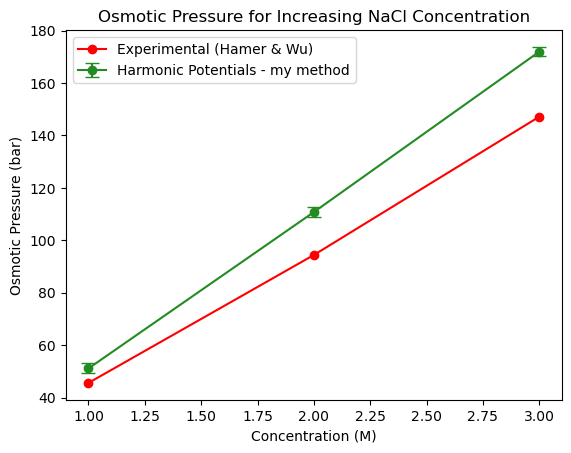

In [ ]:

plt.errorbar(xconc,yHP_OP, yerr=yHP_OPerr, fmt='o', linestyle='-',color='forestgreen', capsize=5, label='Harmonic Potentials - my method')

plt.plot(xconc,yexpOP, marker='o', linestyle='-',color='red', label='Experimental (Hamer & Wu)')

plt.xlabel("Concentration (M)")
plt.ylabel("Osmotic Pressure (bar)")
# plt.title('Osmotic Pressure for Increasing NaCl Concentration')
plt.title('Osmotic Pressure for Increasing NaCl Concentration')
plt.legend()
plt.show()

### Density profiles using GROMACS

In [ ]:
x,y = np.loadtxt("density_original.xvg",comments=["@", "#"],unpack=True)
y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y=y.in_units_of(mole/litre)/2
x1,y1 = np.loadtxt("dens_r1.xvg",comments=["@", "#"],unpack=True)
y1=(y1/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y1=y1.in_units_of(mole/litre)/2
x2,y2 = np.loadtxt("dens_r2.xvg",comments=["@", "#"],unpack=True)
y2=(y2/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y2=y2.in_units_of(mole/litre)/2
x3,y3 = np.loadtxt("dens_r3.xvg",comments=["@", "#"],unpack=True)
y3=(y3/nanometer**3)/(AVOGADRO_CONSTANT_NA)
y3=y3.in_units_of(mole/litre)/2
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(x,y, c='purple', label='original')
plt.plot(x1,y1, c='g', label='rep 1')
plt.plot(x2,y2, c='c', label='rep 2')
plt.plot(x3,y3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Concentration profile - CHARMM27')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

FileNotFoundError: density_original.xvg not found.

## Density profiles using MDanalysis

In [ ]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [ ]:
# nbins,ncounts=density_profile(u,ions,2)
# nbins1,ncounts1=density_profile(u1,ions1,2)
# nbins2,ncounts2=density_profile(u2,ions2,2)
# nbins3,ncounts3=density_profile(u3,ions3,2)

### Density plots

In [ ]:
nb=144.4/72
volbin=48*48*nb*angstrom**3
counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins1=nbins1/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='orange', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()

NameError: name 'ncounts' is not defined